Example file which shows some simple curve fitting using DARTSRegressor and some other estimators.

In [51]:
from functools import partial
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from autora.skl.darts import DARTSRegressor
from autora.synthetic import retrieve, describe

In [52]:
# %% Define some helper functions

def show_results_complete(
    data_: pd.DataFrame,
    estimator=None,
    show_results=True,
    projection="2d",
    label=None,
):
    """
    Function to plot input data (x_, y_) and the predictions of an estimator for the same x_.
    """
    if projection == "2d":
        plt.figure()
        data_.plot.scatter(
            "S1", "S2", c="difference_detected", cmap="viridis", zorder=10
        )
    elif projection == "3d":
        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")
        ax.scatter(data_["S1"], data["S2"], data["difference_detected"])

        if estimator is not None:
            xs, ys = np.mgrid[0:5:0.2, 0:5:0.2]  # type: ignore

            zs = estimator.predict(np.column_stack((xs.ravel(), ys.ravel())))

            ax.plot_surface(xs, ys, zs.reshape(xs.shape), alpha=0.5)

    if label is not None:
        plt.title(label)

    if show_results:
        plt.show()

    return


In [53]:
# %% Load the data
s = retrieve("weber_fechner",rng=np.random.default_rng(seed=180), resolution=20)
X = s.domain()
y = s.experiment_runner(X)
data = pd.DataFrame(np.column_stack([X, y]), columns=["S1", "S2", "difference_detected"])

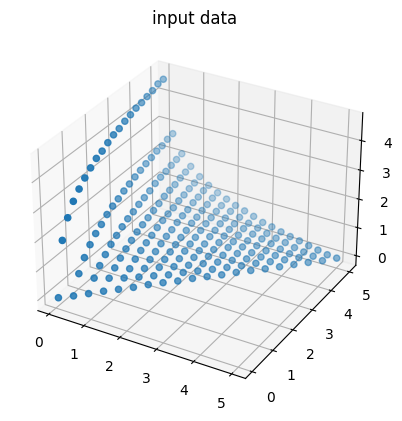

In [54]:
show_results = partial(show_results_complete, data_=data, projection="3d")
show_results(label="input data")

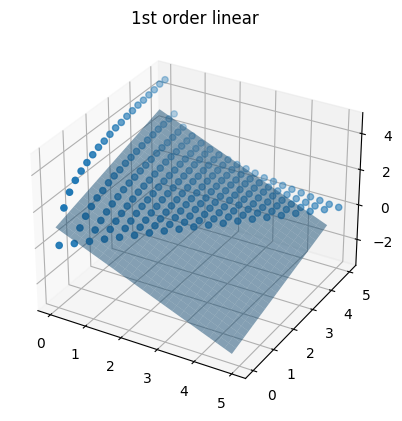

In [55]:
# %% Fit first using a super-simple linear regression

first_order_linear_estimator = LinearRegression()
first_order_linear_estimator.fit(X, y)

show_results(estimator=first_order_linear_estimator, label="1st order linear")

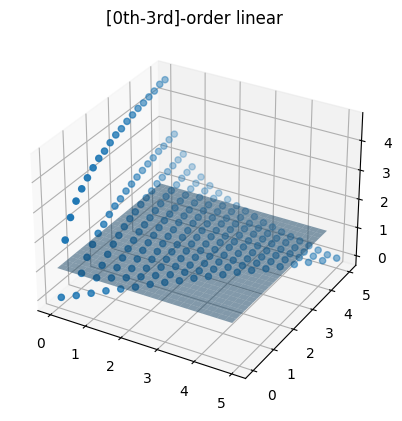

In [56]:
# %% Fit using a 0-3 order polynomial, getting the best fit for the data.
polynomial_estimator = GridSearchCV(
    make_pipeline(PolynomialFeatures(), LinearRegression(fit_intercept=False)),
    param_grid=dict(polynomialfeatures__degree=range(4)),
)
polynomial_estimator.fit(X, y)

show_results(estimator=polynomial_estimator, label="[0th-3rd]-order linear")

  0%|          | 0/30 [00:00<?, ?it/s]

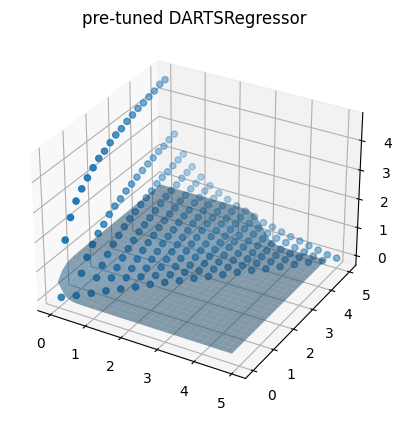

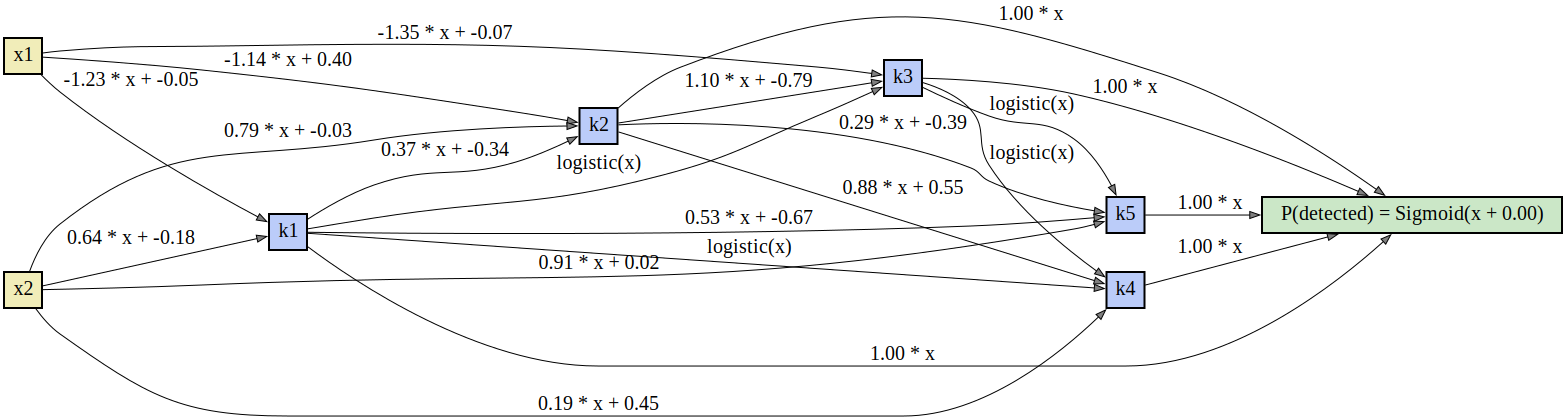

In [57]:
darts_estimator_tuned = DARTSRegressor(
    batch_size=64,
    arch_updates_per_epoch=100,
    param_updates_per_epoch=100,
    max_epochs=30,
    output_type="probability",
    num_graph_nodes=5,
    primitives=[
        "none",
        "linear",
        "logistic",
        ]
)

darts_estimator_tuned.fit(X, y)

show_results(estimator=darts_estimator_tuned, label="pre-tuned DARTSRegressor")
darts_estimator_tuned.visualize_model()

  0%|          | 0/1 [00:00<?, ?it/s]

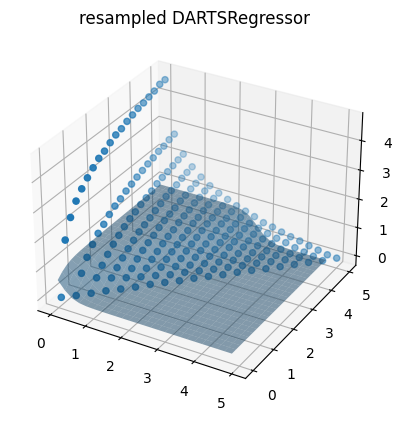

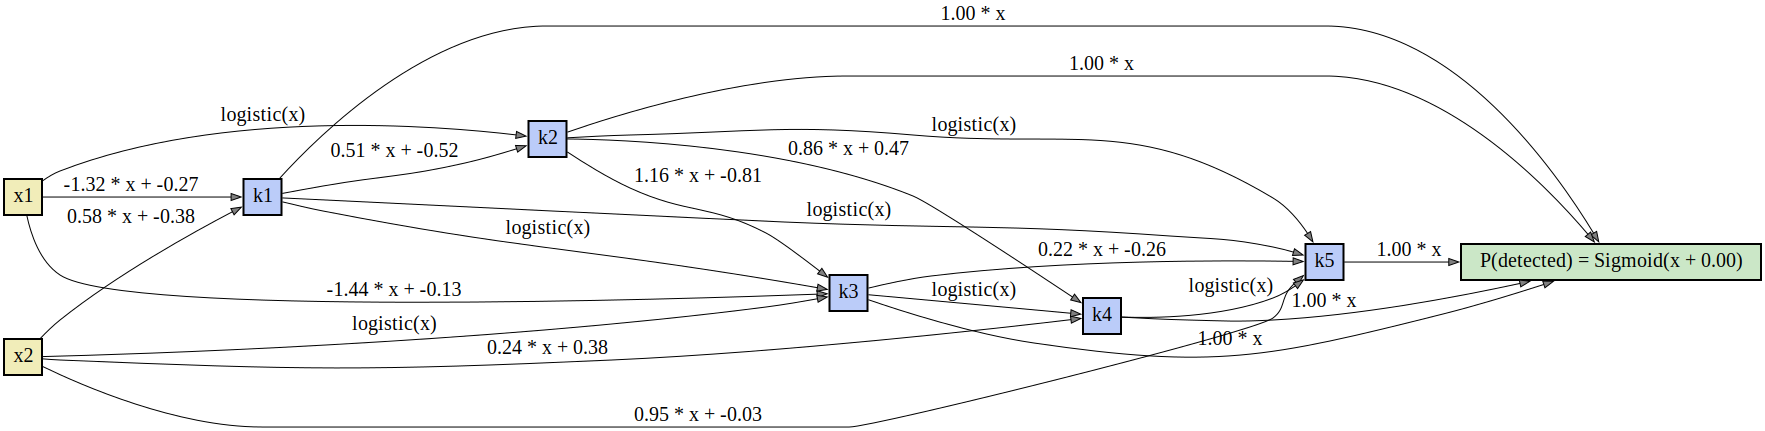

In [58]:
darts_estimator_tuned.set_params(
    arch_updates_per_epoch=0,
    param_updates_per_epoch=1000,
    sampling_strategy="sample",
    max_epochs=1
)
darts_estimator_tuned.fit(X, y)
show_results(estimator=darts_estimator_tuned, label="resampled DARTSRegressor")
darts_estimator_tuned.visualize_model()


0it [00:00, ?it/s]

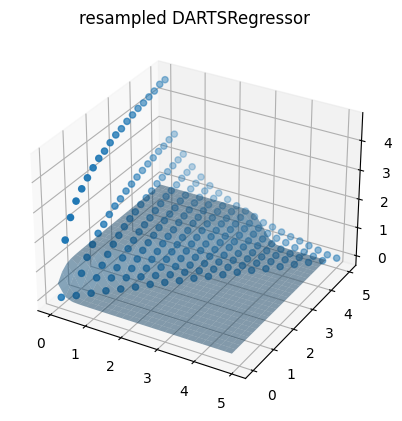

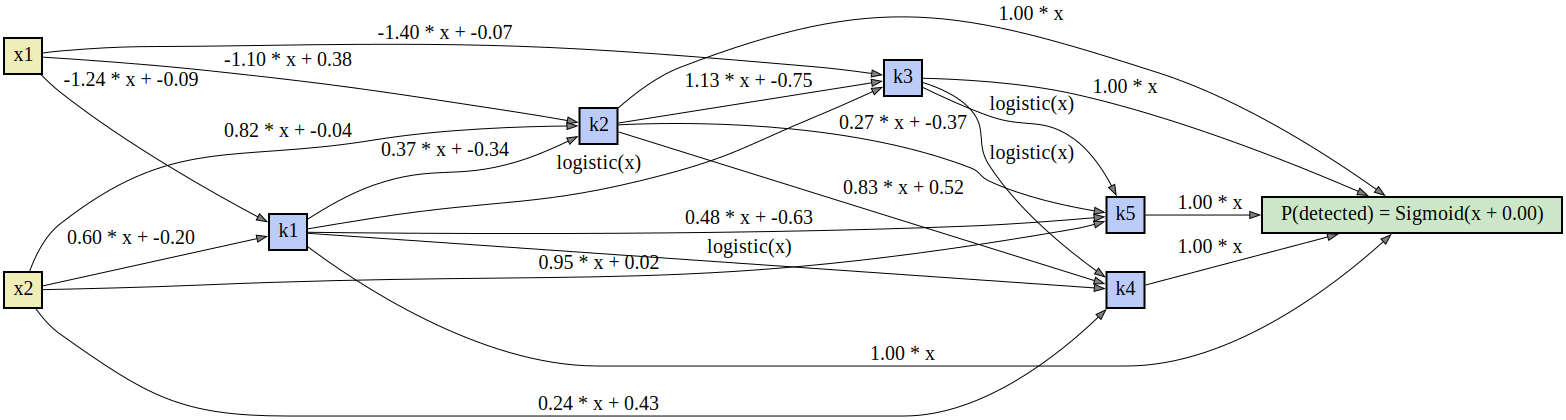

In [59]:
darts_estimator_tuned.set_params(
    arch_updates_per_epoch=0,
    param_updates_per_epoch=1000,
    sampling_strategy="max",
    max_epochs=0
)
darts_estimator_tuned.fit(X, y)
show_results(estimator=darts_estimator_tuned, label="resampled DARTSRegressor")
darts_estimator_tuned.visualize_model()
